In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random
from tqdm.auto import tqdm

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

c:\Users\Swarnarup\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Importing Dataset

In [3]:
# f = open("faithful.dat.txt",'r')
# s=f.read()

# l=s.split()
# df = pd.DataFrame()
# l1=[]
# l2=[]
# for i in range(2,len(l),2):
#     l1.append(float(l[i]))
# for i in range(3,len(l),2):
#     l2.append(float(l[i]))

# df[l[0]] = l1
# df[l[1]] = l2

In [4]:
df = pd.read_csv("faithful.csv")
df = df.drop(columns='Unnamed: 0',axis=1)
cols = df.columns
cols

Index(['eruptions', 'waiting'], dtype='object')

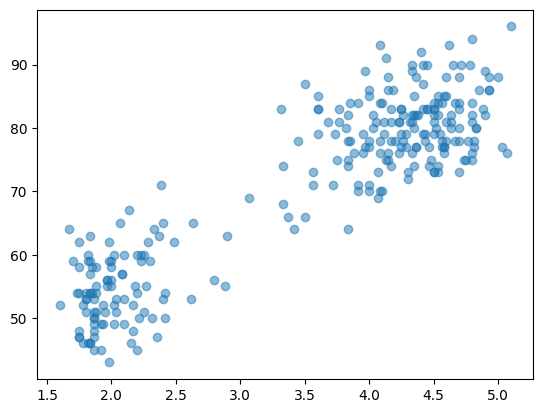

In [5]:
plt.scatter(df[cols[0]],df[cols[1]],alpha=0.5)

In [6]:
df_np = np.array(df)

#### writing functions for EM Estimation

In [7]:
def normal_dist(x, mn, var):
    if np.linalg.det(var) == 0:
        return 0.0
    n = len(x)
    factor = 1/((2**(n/2))*((abs(np.linalg.det(var)))**(1/2)))
    e = np.exp(-((x-mn).T @ np.linalg.inv(var) @ (x-mn)))
    return factor*e

#####
def calc_ɣ(x, l_mn, l_var, l_wt):
    # print("l mn  ",l_mn)
    # print("l var  ",l_var)
    n = len(x)
    k = len(l_mn)
    g_matrix = []
    for i in range(n):
        temp_l=[]
        for j in range(k):        
            # temp = l_wt[j] * multivariate_normal.pdf(x[i], l_mn[j], l_var[j], allow_singular=True)
            temp = l_wt[j] * normal_dist(x[i], l_mn[j], l_var[j])
            # print("temp ",x[i])
            temp_l.append(temp)
        # print("temp_l ",g_matrix)
        g_matrix.append(np.array(temp_l)/sum(temp_l))
    # print("g_matrix", g_matrix)
    return np.array(g_matrix)



#####
def calc_N_k(l_ɣ):
    return l_ɣ.sum(axis=0)

####
def calc_μ(x, l_ɣ, l_N_k):
    k = len(l_N_k)
    # N = l_N_k.sum()
    # print(k)
    l_mu = []
    n,d = x.shape
    # print(n)
    for j in range(k):
        temp=0
        for i in range(n):
            temp+= l_ɣ[i][j]*x[i]
        # temp/=l_N_k
        l_mu.append(temp/l_N_k[j])
    return np.array(l_mu)
        


####
def calc_sigma(x, l_ɣ, l_N_k, l_μ):
    l_sigma = []
    n,d = x.shape
    for j in range(len(l_N_k)):
        temp=np.zeros((d,d))
        for i in range(n):
            arr = np.reshape((x[i] - l_μ[j]),(d,1))
            temp+= l_ɣ[i][j]*(arr @ arr.T)
        # temp/=l_N_k
        
        l_sigma.append(temp/l_N_k[j])
    # print(np.array(l_sigma).shape)
    return np.array(l_sigma)


####
def calc_wt(l_N_k):
    return l_N_k/l_N_k.sum()

####
def calc_LL(x, l_wt, l_mu, l_sigma):
    n,d = x.shape
    k = len(l_mu)
    temp=0
    for i in range(n):
        temp1=0
        for j in range(k):
            # temp1 += l_wt[j]*multivariate_normal.pdf(x[i], l_mu[j,:], l_sigma[j,:,:], allow_singular=True)
            temp1 += l_wt[j]*normal_dist(x[i], l_mu[j], l_sigma[j])
        temp += np.log(temp1)
    return temp



#######
def em_estimate(x, initial_mean, initial_var, initial_wt, max_iterations, threshold):

    l_mean=initial_mean
    l_var=initial_var
    l_wt=initial_wt
    # l_N_k = []

    l_cntrs = [l_mean]

    l_ɣ = np.zeros((len(x),len(l_mean)))

    ll_list=[]
    ll = calc_LL(x, l_wt, l_mean, l_var)

    for iter in tqdm(range(max_iterations), desc='GMM clustering'):
    # for iter in range(max_iterations):
        # print("iter number : ",iter)

        # print(l_mean)
        # print(l_var)
        # print(l_wt)

        # E- step : calculating all the ɣ terms

        l_ɣ = calc_ɣ(x, l_mean, l_var, l_wt)
        # print("jhfajkhf ajhgkfjbf hajf",l_ɣ.shape)
        # print("l_g",l_ɣ)
        l_N_k = calc_N_k(l_ɣ)
        # print("l_N_k",l_N_k)
        # M- step obtain oplimal μ, ɣ and wt

        l_wt = calc_wt(l_N_k)
        # print(l_wt)
        l_mean = calc_μ(x, l_ɣ, l_N_k)
        # print(l_mean)
        l_var = calc_sigma(x, l_ɣ, l_N_k, l_mean)
        # print(l_var)

        ll_latest = calc_LL(x, l_wt, l_mean, l_var)

        ll_list.append(ll)
        if abs(ll - ll_latest)<threshold:
            # print(" jgjh ",abs(ll - ll_latest))
            break

        ll = ll_latest

        l_cntrs.append(l_mean)
        # print("iter number finished: ",iter)
        # print(ll)
    
    return {"means":l_mean, "sigmas":l_var, "weights":l_wt, "list_ll":ll_list, "center_update_list": l_cntrs}
        

#### Using Random points from the Dataset to estimate initial centers

In [8]:
k = 2
n,d = df_np.shape
a = em_estimate(df_np, np.array([df_np[random.randint(0,len(df_np)-1)] for i in range(k)]), np.array([50*np.identity(d) for i in range(k)]), np.array([1/k for i in range(k)]), 50, 0)

GMM clustering:   0%|          | 0/50 [00:00<?, ?it/s]

GMM clustering: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


[ 2.03783339 54.49189871]
[ 4.29103286 79.98526455]


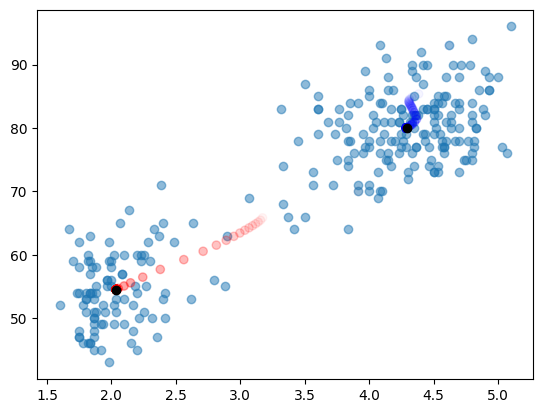

In [9]:
plt.scatter(df_np[:,0],df_np[:,1],alpha=0.5)
for i in range(len(a["center_update_list"])):
    plt.scatter(a["center_update_list"][i][:, 0], a["center_update_list"][i][:, 1], c=['r', 'b'], alpha=(i+1)/len(a["center_update_list"]))

for i in a["means"]:
    print(i)
    plt.scatter(i[0],i[1],color='black')

####  Using _KMeans_ to estimate initial centers

In [10]:
km = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(df)
cntrs = km.cluster_centers_

In [11]:
k = 2
n,d = df_np.shape
model_with_kmc = em_estimate(df_np, cntrs, np.array([100*np.identity(d) for i in range(k)]), np.array([1/k for i in range(k)]), 100, 0.0)

GMM clustering: 100%|██████████| 100/100 [00:12<00:00,  7.69it/s]


[ 2.03783339 54.49189871]
[ 4.29103286 79.98526455]


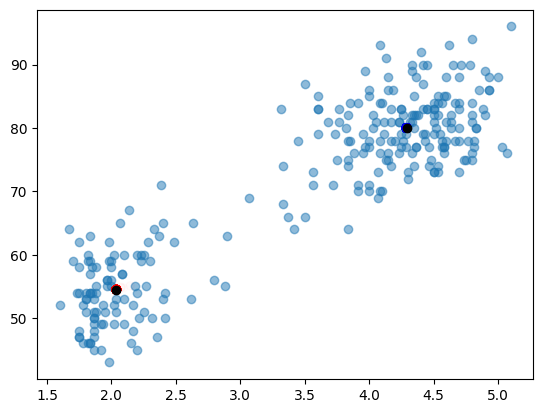

In [12]:
plt.scatter(df_np[:,0],df_np[:,1],alpha=0.5)
for i in range(len(model_with_kmc["center_update_list"])):
    plt.scatter(model_with_kmc["center_update_list"][i][:, 0], model_with_kmc["center_update_list"][i][:, 1], c=['r', 'b'], alpha=(i+1)/len(model_with_kmc["center_update_list"]))
for i in model_with_kmc["means"]:
    print(i)
    plt.scatter(i[0],i[1],color='black')

